In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/UIT/Img Porcessing/Project/NAFNet")

#INSTALLATION

In [ ]:
#!git clone https://github.com/megvii-research/NAFNet

Cloning into 'NAFNet'...
remote: Enumerating objects: 517, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 517 (delta 107), reused 88 (delta 65), pack-reused 360
Receiving objects: 100% (517/517), 16.20 MiB | 11.09 MiB/s, done.
Resolving deltas: 100% (255/255), done.
Checking out files: 100% (126/126), done.


In [3]:
!pip install -r requirements.txt && python setup.py develop --no_cuda_ext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.0 MB 4.3 MB/s 
     |████████████████████████████████| 190 kB 41.5 MB/s 
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
running develop
running egg_info
writing basicsr.egg-info/PKG-INFO
writing dependency_links to basicsr.egg-info/dependency_links.txt
writing top-level names to basicsr.egg-info/top_level.txt
adding license file 'LICENSE'
writing manifest file 'basicsr.egg-info/SOURCES.txt'
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:411: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/basicsr.egg-link (link to .)
Adding basicsr 1.2.0+50cb149 to easy-install.pth file

Installed /content/drive/My

#DATA PREPARATION

In [ ]:
!python scripts/data_preparation/sidd.py

mkdir ./datasets/SIDD/train/input_crops ...
Extract: 100% 320/320 [26:40<00:00,  5.00s/image]
All processes done.
mkdir ./datasets/SIDD/train/gt_crops ...
Extract: 100% 320/320 [28:40<00:00,  5.38s/image]
All processes done.
Reading image path list ...
Create lmdb for ./datasets/SIDD/train/input_crops, save to ./datasets/SIDD/train/input_crops.lmdb...
Total images: 30608
Data size per image is:  514274
Write 0200_SRGB_011_s088: 100% 30608/30608 [2:28:18<00:00,  3.44chunk/s]

Finish writing lmdb.
Reading image path list ...
Create lmdb for ./datasets/SIDD/train/gt_crops, save to ./datasets/SIDD/train/gt_crops.lmdb...
Total images: 30608
Data size per image is:  264792
Write 0200_SRGB_011_s088: 100% 30608/30608 [1:57:11<00:00,  4.35chunk/s]

Finish writing lmdb.


In [ ]:
!nvidia-smi

#BASELINE width32

In [ ]:
!python -m torch.distributed.launch --nproc_per_node=1 --master_port=4321 basicsr/train.py -opt options/train/SIDD/Baseline-width32.yml --launcher pytorch

/usr/local/lib/python3.7/dist-packages/torch/distributed/launch.py:186: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  FutureWarning,
init dist ..  pytorch
Path already exists. Rename it to /content/drive/MyDrive/UIT/Img Porcessing/Project/NAFNet/experiments/Baseline-SIDD-width32_archived_20221110_003421
Path already exists. Rename it to tb_logger/Baseline-SIDD-width32_archived_20221110_003421
2022-11-10 00:34:22,627 INFO: 
                ____                _       _____  ____
               / __ ) ____ _ _____ (_)_____/ ___/ / __ \
              / __  |/ __ `// ___// // ___/\__ \ / /_/ /
             / /_/ // /_/ /(__  )/ // /__ ___/ // _, _/
          

#NAFNet width32

In [ ]:
!python -m torch.distributed.launch --nproc_per_node=1 --master_port=4321 basicsr/train.py -opt options/train/SIDD/NAFNet-width32.yml --launcher pytorch

/usr/local/lib/python3.7/dist-packages/torch/distributed/launch.py:186: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  FutureWarning,
init dist ..  pytorch
2022-11-11 03:35:31,613 INFO: 
                ____                _       _____  ____
               / __ ) ____ _ _____ (_)_____/ ___/ / __ \
              / __  |/ __ `// ___// // ___/\__ \ / /_/ /
             / /_/ // /_/ /(__  )/ // /__ ___/ // _, _/
            /_____/ \__,_//____//_/ \___//____//_/ |_|
     ______                   __   __                 __      __
    / ____/____   ____   ____/ /  / /   __  __ _____ / /__   / /
   / / __ / __ \ / __ \ / __  /  / /   / / / // ___// //_/  / /
  

In [4]:
import torch

from basicsr.models import create_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.utils.options import parse
import numpy as np
import cv2
import matplotlib.pyplot as plt

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img
def img2tensor(img, bgr2rgb=False, float32=True):
    img = img.astype(np.float32) / 255.
    return _img2tensor(img, bgr2rgb=bgr2rgb, float32=float32)

def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1) 
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('NAFNet output', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)

def single_image_inference(model, img, save_path):
      model.feed_data(data={'lq': img.unsqueeze(dim=0)})

      if model.opt['val'].get('grids', False):
          model.grids()

      model.test()

      if model.opt['val'].get('grids', False):
          model.grids_inverse()

      visuals = model.get_current_visuals()
      sr_img = tensor2img([visuals['result']])
      imwrite(sr_img, save_path)

#LOAD Baseline32 self-trained

In [5]:
opt_path = 'options/test/SIDD/Baseline-width32.yml'
opt = parse(opt_path, is_train=False)
opt['dist'] = False
Base_self = create_model(opt)

 load net keys <built-in method keys of collections.OrderedDict object at 0x7fa925048a70>


#LOAD Baseline32 Pre-trained

In [ ]:
import gdown
# gdown.download("https://drive.google.com/u/0/uc?id=1NhqVcqkDcYvYgF_P4BOOfo9tuTcKDuhW",
              #  "experiments/pretrained_models/",)

In [6]:
opt_path = 'options/test/SIDD/Baseline-width32.yml'
opt = parse(opt_path, is_train=False)
opt['dist'] = False
opt['path']['pretrain_network_g'] = "experiments/pretrained_models/Baseline-SIDD-width32.pth"
Base_pretrained = create_model(opt)

 load net keys <built-in method keys of collections.OrderedDict object at 0x7fa924d98830>


# LOAD NAFNet_40 Self-trained (40K iters, width32)


In [7]:
opt_path = 'options/test/SIDD/NAFNet-width32.yml'
opt = parse(opt_path, is_train=False)
opt['dist'] = False
opt['path']['pretrain_network_g'] = "experiments/NAFNet-SIDD-width32/models/net_g_40000.pth"
NAFNet40_self = create_model(opt)

 load net keys <built-in method keys of collections.OrderedDict object at 0x7fa924bb09e0>


# LOAD NAFNet_60 Self-trained (60K iters, width32)

In [8]:
opt_path = 'options/test/SIDD/NAFNet-width32.yml'
opt = parse(opt_path, is_train=False)
opt['dist'] = False
opt['path']['pretrain_network_g'] = "experiments/NAFNet-SIDD-width32/models/net_g_60000.pth"
NAFNet60_self = create_model(opt)

 load net keys <built-in method keys of collections.OrderedDict object at 0x7fa92494f320>


# LOAD NAFNet Pretrained (width32)

In [9]:
opt_path = 'options/test/SIDD/NAFNet-width32.yml'
opt = parse(opt_path, is_train=False)
opt['dist'] = False
opt['path']['pretrain_network_g'] = "experiments/pretrained_models/NAFNet-SIDD-width32.pth"
NAFNet_pretrained = create_model(opt)

 load net keys <built-in method keys of collections.OrderedDict object at 0x7fa9247358c0>


#INFERENCE & DISPLAY

In [10]:
def inference(model, img):
      model.feed_data(data={'lq': img.unsqueeze(dim=0)})

      if model.opt['val'].get('grids', False):
          model.grids()

      model.test()

      if model.opt['val'].get('grids', False):
          model.grids_inverse()

      visuals = model.get_current_visuals()
      result_img = tensor2img([visuals['result']])
      # plt.imshow(result_img)
      return result_img

In [ ]:
inp_path = "/content/drive/MyDrive/UIT/Img Porcessing/Project/NAFNet/demo_input/noisy-demo-0.png"
img = imread(inp_path)
inp = img2tensor(img)
res_60 = inference(NAFNet60_self, inp)
# res_40 = inference(NAFNet40_self, inp)
# res_NAF_pre = inference(NAFNet_pretrained, inp)

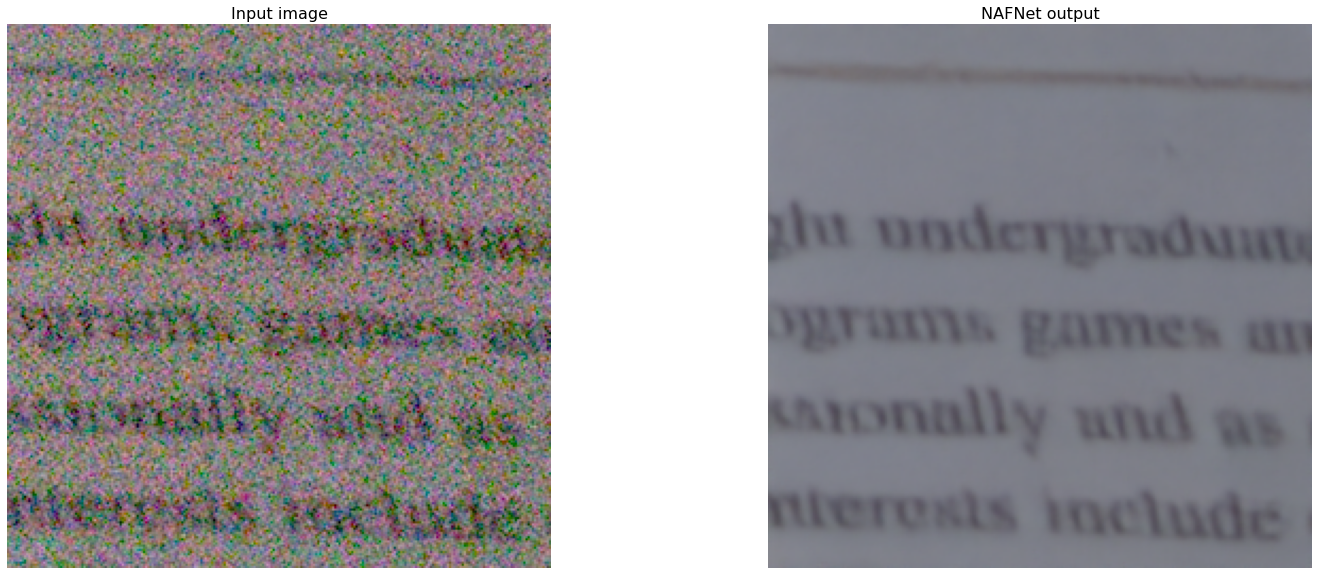

In [ ]:
display(img, res_60)

In [ ]:
inp_path = "/content/drive/MyDrive/UIT/Img Porcessing/Project/NAFNet/demo_input/balloons_noisy.png"
img = imread(inp_path)
inp = img2tensor(img)
res_60 = inference(NAFNet60_self, inp)
res_40 = inference(NAFNet40_self, inp)
res_NAFNet_pre = inference(NAFNet_pretrained, inp)

In [ ]:
def display2img(img1, img2, isCvt1=False, isCvt2=False, label1='Input image', label2='NAFNet output'):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1) 
  plt.title(label1, fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title(label2, fontsize=16)
  ax2.axis('off')
  if (isCvt1):
    img1_show = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    ax1.imshow(img1_show)
  else:
    ax1.imshow(img1)
  if(isCvt2):
    img2_show = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    ax2.imshow(img2_show)
  else: 
    ax2.imshow(img2)

In [ ]:
display2img(img, res_40, isCvt2=True, label2="NAFNet_40K output")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
display2img(res_60, res_NAFNet_pre, isCvt1=True, isCvt2=True, label2="NAFNet_Pretrained output", label1="NAFNet_60K output")

Output hidden; open in https://colab.research.google.com to view.

#DEPLOY WITH GRADIO

In [11]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 4.3 MB/s 
     |████████████████████████████████| 2.3 MB 44.4 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 213 kB 60.2 MB/s 
     |████████████████████████████████| 272 kB 59.8 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 106 kB 55.2 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 64 kB 2.9 MB/s 
     |████████████████████████████████| 80 kB 8.7 MB/s 
     |████████████████████████████████| 68 kB 6.7 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 856 kB 63.0 MB/s 
     |████████████████████████████████| 4.1 MB 39

In [12]:
models_dict = {"Baseline Pretrained":Base_pretrained, 
               "Baseline Self-trained": Base_self,
               "NAFNet Pretrained": NAFNet_pretrained,
               "NAFNet-40K Self-trained": NAFNet40_self,
               "NAFNet-60K Self-trained": NAFNet60_self}
def denoise(image,model_name="NAFNet Pretrained"):
  img_tensor = img2tensor(image)
  model = models_dict[model_name]
  res_img = inference(model, img_tensor)
  return cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB)

In [13]:
import gradio
os.chdir("/content/drive/MyDrive/UIT/Img Porcessing/Project/NAFNet")
examples = [["demo_input/noisy-demo-0.png", "Baseline Pretrained"], 
            ["demo_input/noisy_checkboard_256.gif", "Baseline Self-trained"], 
            ["demo_input/noisy_fruit_256.png", "NAFNet Pretrained"], 
            ["demo_input/noisy-demo-1.png", "NAFNet-60K Self-trained"], 
            ["demo_input/lena_512_noisy.png", "NAFNet-40K Self-trained"],
           ]
inputs=[gradio.Image(elem_id="input_image", value="demo_input/noisy-demo-0.png"),
        gradio.Dropdown(list(models_dict.keys()), value="Baseline Pretrained")]
style_css = """
                #input_image div:last-of-type{height:auto !important}
                #input_image div:last-of-type div:first-of-type{
                  max-height: none !important
                }
            """


interface = gradio.Interface(fn=denoise, inputs=inputs, outputs="image", examples=examples,
                             css=style_css)
interface.launch(share=True)
# interface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://2d39a74628f8e90b.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7fa917ac4890>,
 'http://127.0.0.1:7860/',
 'https://2d39a74628f8e90b.gradio.app')

# DEPLOY VIA HUGGING FACE

In [ ]:
os.chdir('/content')

In [ ]:
!git clone https://huggingface.co/spaces/HungDuong/NAFNet_Study

Cloning into 'NAFNet_Study'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.


In [ ]:
os.chdir('NAFNet_Study/')

In [ ]:
!touch app.py

In [ ]:
!git config --global "duongngochung13@gmail.com"
!git config --global user.name "HungDuong"

error: invalid key: duongngochung13@gmail.com


In [ ]:
!git add app.py
!git commit -m "Add application file"
!git push


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@946c120dbe0a.(none)')
fatal: could not read Username for 'https://huggingface.co': No such device or address
